In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
import numpy as np

from PIL import Image
import tiktoken
from dataclasses import dataclass
from datasets import load_dataset

import os, io, tarfile

import matplotlib.pyplot as plt

In [2]:
# ------------------------------
# Shared Transformer Blocks
# ------------------------------

class MLP(nn.Module):
    """linear layer + non-linearity to add compute after multi-head attention"""

    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd) # expand onto higher dimensional space
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd) # project back down to model's embedding dimensionality 

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Attention(nn.Module):
    """multiple self-attention heads in parallel"""

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, batched together
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.is_decoder = config.is_decoder


    def forward(self, x):
        B, T, C = x.shape # batch size, sequence length, n_embd
        # calculate query, key, value for all heads in a batch
        # C = n_head * head_size, eg n_head = 12, head_size = 64, so C = 768
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, -1).transpose(1, 2) #(B, T, n_head, head_size) -> (B, n_head, T, head_size)
        q = q.view(B, T, self.n_head, -1).transpose(1, 2) #(B, T, n_head, head_size) -> (B, n_head, T, head_size)
        v = v.view(B, T, self.n_head, -1).transpose(1, 2) #(B, T, n_head, head_size) -> (B, n_head, T, head_size)
        
        # use flash attention instead of manually implemented attention
        y = F.scaled_dot_product_attention(q, k, v, is_causal=self.is_decoder) # (B, n_head, T, head_size)
        
        y = y.transpose(1, 2).reshape(B, T, -1) # (B, n_head, T, head_size) -> (B, T, n_head * head_size)

        y = self.c_proj(y) 
        return y

class Block(nn.Module):
    """transformer block: communication followed by computation, with resid connection (x +)"""

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = Attention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config) 

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [3]:
# ------------------------------
# Text Decoder (GPT-style)
# ------------------------------

@dataclass
class TextConfig:
    n_layer: int = 6
    n_head: int = 8
    n_embd: int = 512
    out_dim: int = 512
    is_decoder: bool = True
    block_size: int = 77
    vocab_size: int = 50258 # from TextTokenizer

class TextDecoder(nn.Module):
    """GPT-style transformer decoder for text embeddings."""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.proj = nn.Linear(config.n_embd, config.out_dim, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        # Use pytorch default LayerNorm init

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        
        # idx and targets are both (B, T) tensor of integers
        token_emb = self.transformer.wte(idx) # (B, T, C = n_embd)
        pos_emb = self.transformer.wpe(torch.arange(T, device=idx.device)) # (T, C = n_embd)
        x = token_emb + pos_emb # (B, T, C = n_embd)
        for block in self.transformer.h:
            x = block(x) # (B, T, C = n_embd)
        x = self.transformer.ln_f(x)
        # Find first occurrence of eot_token_id (50256)
        # TODO: don't hardcode EOT token id
        eot_positions = (idx == 50256).int().argmax(dim=-1)  # (B,)
        eot_token = x[torch.arange(x.shape[0]), eot_positions]  # (B, C = n_embd)
        out = self.proj(eot_token) # (B, C = out_dim)
        out = out / out.norm(dim=-1, keepdim=True) # normalize to unit length for cosine similarity

        return out

In [4]:
# ------------------------------
# Text Tokenizer
# ------------------------------

class TextTokenizer: 
    """ 
    tiktoken Wrapper
    Not quite CLIP tokenizer, but approximates it using GPT-2 tokenizer 
    Vocab size = GPT-2 vocab size (50257) + 1 (for new SOT token) = 50258
    """

    def __init__(self, config):
        self.enc = tiktoken.get_encoding("gpt2")
        # Special tokens
        self.eot_token = "<|endoftext|>"
        self.pad_token = self.eot_token
        self.sot_token = "<|startoftext|>"
        self.eot_token_id = 50256 # already exists in GPT-2 tokenizer
        self.pad_token_id = self.eot_token_id
        self.sot_token_id = self.eot_token_id + 1 # doesn't exist in GPT-2 tokenizer
        
        self.block_size = config.block_size

    def encode(self, text):
        tokens = [self.sot_token_id]
        text_enc = self.enc.encode(text)
        if len(text_enc) + 2 > self.block_size:
            tokens.extend(text_enc[:self.block_size - 2])
        else:
            tokens.extend(text_enc)
            if len(tokens) < self.block_size:
                tokens.extend([self.pad_token_id] * (self.block_size - 1 - len(tokens)))
        tokens.extend([self.eot_token_id])
        return torch.tensor(tokens, dtype=torch.long)

    def decode(self, ids, include_special_tokens=True):
        result = ""
        for id in ids.tolist():
            if id == self.sot_token_id:
                if include_special_tokens:
                    result += self.sot_token
            elif id == self.eot_token_id:
                if include_special_tokens:
                    result += self.eot_token
            else:
                result += self.enc.decode([id])
        return result

In [5]:
# ------------------------------
# Vision Encoder
# ------------------------------

@dataclass
class VisionConfig:
    n_layer: int = 8
    n_head: int = 6
    n_embd: int = 768
    out_dim: int = 512
    is_decoder: bool = False
    img_size: int = 224 # 224x224 image
    patch_size: int = 16 # 16x16 patches

class PatchEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.img_size = config.img_size
        self.patch_size = config.patch_size
        assert self.img_size % self.patch_size == 0
        self.conv = nn.Conv2d(in_channels=3, out_channels=config.n_embd, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.conv(x) # [B, C=3, S=224, S=224] -> [B, C=768, N=14, N=14] 
        x = x.flatten(2) # [B, C=768, N=14, N=14] -> [B, C=768, N**2=T=196] 
        x = x.transpose(1,2)  #[B, C, T] -> [B, T=196, C=768] 

        return x

class VisionEncoder(nn.Module):
    """vision transformer encoder for image embeddings"""

    def __init__(self, config):
        super().__init__()
        self.config = config

        assert config.img_size % config.patch_size == 0
        self.n_patch = (config.img_size // config.patch_size)**2 # N**2 = (224/16)**2 = 196
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.n_embd)) # extra learnable token
        
        self.transformer = nn.ModuleDict(dict(
            patch_emb = PatchEmbedding(config),
            pos_emb = nn.Embedding(self.n_patch + 1, config.n_embd), # +1 for cls_token
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.proj = nn.Linear(config.n_embd, config.out_dim, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        # Use pytorch default LayerNorm & Conv2d init
        
    def forward(self, x):
        x = self.transformer.patch_emb(x) # [B, C=3, S=224, S=224] -> [B, T=196, C=768]
        B, T, C = x.shape

        # add cls_token to each batch
        x = torch.cat((self.cls_token.expand(B, -1, -1), x), dim=1) # [B, 197, C=768]
        # add positional embedding
        pos_emb = self.transformer.pos_emb(torch.arange(T+1, device=x.device)) # [197, C=768]
        x = x + pos_emb # [B, 197, C=768]
        for block in self.transformer.h:
            x = block(x) # [B, 197, C=768]
        x = self.transformer.ln_f(x) # [B, 197, C=768]
        cls_token = x[:, 0, :] # [B, 197, C=768] -> [B, C=768]
        out = self.proj(cls_token) # [B, C=768] -> [B, C=512]
        out = out / out.norm(dim=-1, keepdim=True) # normalize to unit length for cosine similarity

        return out

In [6]:
# Image utils

vision_config = VisionConfig()

# image to tensor
itot = transforms.Compose([
  transforms.Resize((vision_config.img_size, vision_config.img_size)),
  transforms.ToTensor()
])
# tensor to image
ttoi = transforms.ToPILImage()

# sample image loader
def load_image(name):
    dir = "./data/sample"
    file = f"{dir}/{name}"
    return itot(Image.open(file).convert("RGB"))

def show_tensor_image(image):
    image = ttoi(image)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [7]:
# ------------------------------
# Verify TextDecoder and VisionEncoder output shapes
# ------------------------------

# TextDecoder
text_config = TextConfig()
enc = TextTokenizer(text_config)
model = TextDecoder(text_config)

labels = torch.stack([
    enc.encode("a boy and a girl"),
    enc.encode("a red ball"),
    enc.encode("a boy and a girl playing soccer in the park with a red ball"),
])

print(f"labels minibatch shape (B, L=77): {labels.shape}")

label_emb = model(labels)
print(f"label_emb shape (B, C=512): {label_emb.shape}")
print()

# VisionEncoder
images = torch.stack([
    load_image("1.jpg"),
    load_image("2.jpg"),
    load_image("1.jpg")
])

print(f"images minibatch shape (B, C=3, H=224, W=224): {images.shape}")

vision_encoder = VisionEncoder(vision_config)
image_emb = vision_encoder(images)

print(f"image_emb shape (B, C=512): {image_emb.shape}")


labels minibatch shape (B, L=77): torch.Size([3, 77])
label_emb shape (B, C=512): torch.Size([3, 512])

images minibatch shape (B, C=3, H=224, W=224): torch.Size([3, 3, 224, 224])
image_emb shape (B, C=512): torch.Size([3, 512])


In [8]:
# ------------------------------
# Toy example: cosine similarity & contrastive loss
# ------------------------------

# example (B=3, C=3) matrix 1
x = torch.tensor([[1, 2, 3], [-4, 5, 10], [1, -1, 1]], dtype=torch.float32)
x = x / x.norm(dim=-1, keepdim=True)
# example (B=3, C=3) matrix 2
y = torch.tensor([[2, 4, 6], [-2, 4, 6], [2, -4, 6]], dtype=torch.float32)
y = y / y.norm(dim=-1, keepdim=True)
print(f"x:\n{x}")
print(f"y:\n{y}")

# cosine similarity matrix
dot_product = x @ y.T 
print(f"x @ y.T:\n{dot_product}")

# scale by learnable temperature 
logit_scale = torch.ones([]) * np.log(1 / 0.07)
logits = dot_product * logit_scale.exp()
print(f"logits:\n{logits}")

# contrastive loss
targets = torch.arange(x.shape[0])
l_x = F.cross_entropy(logits, targets)
l_y = F.cross_entropy(logits.T, targets)
loss = (l_x + l_y) / 2.0
print(f"loss:\nl_x = {l_x:.4f} | l_y = {l_y:.4f} | loss = {loss:.4f}")

x:
tensor([[ 0.2673,  0.5345,  0.8018],
        [-0.3369,  0.4211,  0.8422],
        [ 0.5774, -0.5774,  0.5774]])
y:
tensor([[ 0.2673,  0.5345,  0.8018],
        [-0.2673,  0.5345,  0.8018],
        [ 0.2673, -0.5345,  0.8018]])
x @ y.T:
tensor([[1.0000, 0.8571, 0.4286],
        [0.8103, 0.9903, 0.3601],
        [0.3086, 0.0000, 0.9258]])
logits:
tensor([[14.2857, 12.2449,  6.1224],
        [11.5753, 14.1475,  5.1446],
        [ 4.4087,  0.0000, 13.2260]])
loss:
l_x = 0.0654 | l_y = 0.0682 | loss = 0.0668


In [9]:
# ------------------------------
# CLIP Model
# ------------------------------

class CLIP(nn.Module):
    def __init__(self, text_config, vision_config):
        super().__init__()
        self.text_decoder = TextDecoder(text_config)
        self.vision_encoder = VisionEncoder(vision_config)
        # learnable temperature parameter (initialized to match CLIP)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def forward(self, labels, images):
        # embed labels & images
        label_emb = self.text_decoder(labels)
        image_emb = self.vision_encoder(images)
        # normalize embeddings
        label_emb = label_emb / label_emb.norm(dim=-1, keepdim=True)
        image_emb = image_emb / image_emb.norm(dim=-1, keepdim=True)
        # clamp temperature
        logit_scale = torch.clamp(self.logit_scale, max=np.log(100))
        logits = logit_scale.exp() * label_emb @ image_emb.T
        # compute contrastive loss
        targets = torch.arange(logits.shape[0])
        loss = (F.cross_entropy(logits, targets) + F.cross_entropy(logits.T, targets)) / 2.0
        return loss

In [10]:
# ------------------------------
# test one forward pass
# ------------------------------

model = CLIP(text_config, vision_config)
loss = model(labels, images)
print(f"loss: {loss:.4f}")

loss: 1.1189


Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

{'jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x1573881F0>, 'json': {'prompt': 'A group of people is gathered under a large tree with green leaves. In the center, a man is wearing a colorful shirt with a yellow and red design and a matching headband. He is standing with his hands pressed together in a prayer gesture. Surrounding him are other individuals, some of whom are also wearing headbands. The group appears to be participating in a ceremony or event.'}, '__key__': 'flux_512_100k_00000000', '__url__': 'hf://datasets/jackyhate/text-to-image-2M@main/data_512_2M/data_000000.tar'}
A group of people is gathered under a large tree with green leaves. In the center, a man is wearing a colorful shirt with a yellow and red design and a matching headband. He is standing with his hands pressed together in a prayer gesture. Surrounding him are other individuals, some of whom are also wearing headbands. The group appears to be participating in a ceremony or event.


TypeError: object of type 'IterableDataset' has no len()

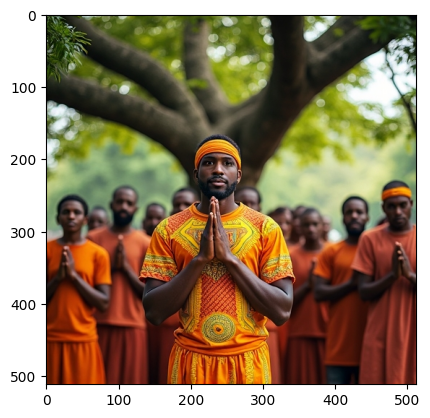

In [ ]:
# ------------------------------
# test loading dataset 
# jackyhate/text-to-image-2M 
# ------------------------------

from datasets import load_dataset
base_url = "https://huggingface.co/datasets/jackyhate/text-to-image-2M/resolve/main/data_512_2M/data_{i:06d}.tar"
num_shards = 46  # Number of webdataset tar files
urls = [base_url.format(i=i) for i in range(num_shards)]
dataset = load_dataset("webdataset", data_files={"train": urls}, split="train", streaming=True)
# Example of iterating through the dataset
for image in dataset:
    print(image)
    print(image["json"]['prompt'])
    plt.imshow(image["jpg"])
    break
# Check the size of the dataset


In [20]:
# ------------------------------
# process & save dataset to tar shards
# ------------------------------

import os, io, tarfile

max_images = 4096
img_size = 224
shard_size = 1024
n_val_shard = 1

shard_dir = "./.cache/data/text-to-image-2M"
os.makedirs(shard_dir, exist_ok=True)

text_config = TextConfig()
tokenizer = TextTokenizer(text_config)
# load dataset in streaming mode
base_url = "https://huggingface.co/datasets/jackyhate/text-to-image-2M/resolve/main/data_512_2M/data_{i:06d}.tar"
num_shards = 46
urls = [base_url.format(i=i) for i in range(num_shards)]
dataset = load_dataset("webdataset", data_files={"train": urls}, split="train", streaming=True)

resize = transforms.Compose([
    transforms.Resize((img_size, img_size)),
])

def process_sample(sample):
    # get image and prompt
    image = sample["jpg"]
    prompt = sample["json"]["prompt"]
    # resize image to img_size
    image = resize(image)
    # convert image to bytes
    img_bytes = io.BytesIO()
    image.save(img_bytes, format="JPEG")
    img_bytes.seek(0)
    # encode prompt
    tokens = tokenizer.encode(prompt)    
    # convert tokens to bytes
    token_bytes = io.BytesIO()
    torch.save(tokens, token_bytes)
    token_bytes.seek(0)
    return img_bytes, token_bytes

# process samples and create tar shards
img_index = 0
next_shard_index = 0
current_shard_count = 0
tar_file = None
tar_path = None

import time; start_time = time.time()

for sample in dataset:
    if img_index >= max_images:
        break
    # start new shard if needed
    if current_shard_count == 0:
        if tar_file is not None:
            tar_file.close()
        split = "val" if next_shard_index < n_val_shard else "train"
        # create new tar shard
        tar_path = os.path.join(shard_dir, f"text_to_image_{split}_{next_shard_index:06d}.tar")
        tar_file = tarfile.open(tar_path, "w")
        next_shard_index += 1
    # process sample
    img_bytes, token_bytes = process_sample(sample)
    # add image to tar
    img_name = f"{img_index:07d}.jpg"
    img_info = tarfile.TarInfo(name=img_name)
    img_info.size = len(img_bytes.getvalue())
    tar_file.addfile(img_info, img_bytes)
    # add tokens to tar
    token_name = f"{img_index:07d}.pth"
    token_info = tarfile.TarInfo(name=token_name)
    token_info.size = len(token_bytes.getvalue())
    tar_file.addfile(token_info, token_bytes)
    # update indices and reset shard counter if full
    img_index += 1
    current_shard_count += 1
    if current_shard_count >= shard_size:
        current_shard_count = 0

    if img_index % 1000 == 0:
        print(f"Processed {img_index}/{max_images} images")

# close final shard
if tar_file is not None:
    tar_file.close()

print(f"Done! Created {next_shard_index} shards with {img_index} images total.")

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")


Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

Processed 1000/4096 images
Processed 2000/4096 images
Processed 3000/4096 images
Processed 4000/4096 images
Done! Created 4 shards with 4096 images total.
Time taken: 17.16 seconds


In [ ]:
# ------------------------------
# test loading dataset from tar shards
# ------------------------------

import os, io, tarfile

shard_dir = "./.cache/data/text-to-image-2M"
limit = 3

for shard in os.listdir(shard_dir):
    if not shard.endswith(".tar"):
        continue
    shard_path = os.path.join(shard_dir, shard)
    tar = tarfile.open(shard_path, "r")
    print(f"Sampling from shard: {shard}")
    # sample one image 
    img_name = tar.getnames()[0]
    img_bytes = tar.extractfile(img_name).read()
    img = Image.open(io.BytesIO(img_bytes))
    plt.imshow(img)
    plt.show()
    # sample one label
    token_name = tar.getnames()[1]
    token_bytes = tar.extractfile(token_name).read()
    tokens = torch.load(io.BytesIO(token_bytes))
    print(tokenizer.decode(tokens))
    tar.close()
    limit -= 1
    if limit == 0:
        break